# Examine the relationship between horizontal salinity gradients and numerical mixing for the parent and child models.
## Smolarkiewicz (1983) showed that $    \frac{1}{2}(|u|\Delta x-u^2 \Delta t) \big(\frac{\partial s}{\partial x} \big)^2 = \frac{1}{2}|u|\Delta x \big(1-\frac{u \Delta t}{\Delta x} \big)\big(\frac{\partial s}{\partial x} \big)^2,$
## Here, we modify this to investigate the relationship between $\mathcal{M}_{num, on}$ and $\big(\frac{\partial s}{\partial x} \big)^2+\big(\frac{\partial s}{\partial y} \big)^2$ 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
import glob
from datetime import datetime
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import matplotlib.ticker as tick

#Dask
# from dask.distributed import Client

# client = Client()
# client


# Save the numerical mixing, salinity gradient magnitude, and grid cell volume dV before starting the regression analysis 

In [ ]:
# path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
# ds = xroms.open_mfnetcdf(path)
# ds, grid = xroms.roms_dataset(ds)

# #Indexing for nested grid
# xislice = slice(271,404)
# etaslice = slice(31,149)

# path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
# ds_child = xroms.open_mfnetcdf(path1)
# ds_child, grid_child = xroms.roms_dataset(ds_child)

# xislicechild = slice(8, 677-8)
# etaslicechild = slice(8, 602-8)

# #Match the times of the parent and child models. Drop the first timestep after
# #each restart, then match parent / child. They differ bc the model crashed mid run
# timedrop = [np.datetime64('2010-06-18T18:30:00.000000000'), 
#             np.datetime64('2010-06-19T18:30:00.000000000'), 
#             np.datetime64('2010-07-09T18:30:00.000000000')]

# ds_child = ds_child.where((ds_child.ocean_time!= timedrop[0])
#                            & (ds_child.ocean_time!= timedrop[1])
#                            & (ds_child.ocean_time!= timedrop[2]),
#                               drop=True)

# ds = ds.where(ds_child.ocean_time==ds.ocean_time)

# def salinity_gradient_mag(ds, grid):
#     '''
# Computes the salinity gradient magnitude for the entire
# water column on the rho points.
#     ''' 
#     dsaltdxi, dsaltdeta = xroms.hgrad(ds.salt, grid)
#     dsaltdxi_rho = grid.interp(xroms.to_rho(dsaltdxi, grid), 'Z')
#     dsaltdeta_rho = grid.interp(xroms.to_rho(dsaltdeta, grid), 'Z')
#     sgradmag = (dsaltdxi_rho**2+dsaltdeta_rho**2)**(1/2)
#     sgradmag.attrs = ''
#     sgradmag.name = 'sgradmag'
    
#     return sgradmag

# #Salinity gradient magnitude 
# sgradmag_whole = salinity_gradient_mag(ds, grid)
# sgradmag = sgradmag_whole.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# sgradmag.attrs = ''
# sgradmag.name = 'sgradmag'

# #Numerical mixing 
# mnum_rho = ds.dye_03
# mnum = mnum_rho.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# mnum.attrs = ''
# mnum.name = 'mnum'

# dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# dV.attrs = ''
# dV.name = 'dV'

# #Child grid --------
# sgradmag_whole_child = salinity_gradient_mag(ds_child, grid_child)
# sgradmag_child = sgradmag_whole_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# sgradmag_child.attrs = ''
# sgradmag_child.name = 'sgradmag'

# mnum_rho_child = ds_child.dye_03.sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# mnum_child = mnum_rho_child.isel(eta_rho = etaslicechild, xi_rho = xislicechild)
# mnum_child.attrs = ''
# mnum_child.name = 'mnum'

# dV_child = ds_child.dV.isel(eta_rho = etaslicechild, xi_rho = xislicechild).sel(ocean_time = slice('2010-06-03', '2010-07-14'))
# dV_child.attrs = ''
# dV_child.name = 'dV'

# #Save the data to a netcdf file 
# mnum.to_netcdf('mnum.nc')
# sgradmag.to_netcdf('sgradmag.nc')
# dV.to_netcdf('dV.nc')

# mnum_child.to_netcdf('mnum_child.nc')
# sgradmag_child.to_netcdf('sgradmag_child.nc')
# dV_child.to_netcdf('dV_child.nc')

# Open data for saving to histograms. We square the salinity gradient magnitude

In [2]:
mnum = xr.open_dataset('../analysis_notebooks/mnum.nc', chunks=dict(ocean_time = 1)).mnum.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
sgradmag = xr.open_dataset('../analysis_notebooks/sgradmag.nc', chunks=dict(ocean_time = 1)).sgradmag.sel(ocean_time = slice('2010-06-03', '2010-07-13'))**2
dV = xr.open_dataset('../analysis_notebooks/dV.nc', chunks=dict(ocean_time = 1)).dV.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

mnum_child = xr.open_dataset('../analysis_notebooks/mnum_child.nc', chunks=dict(ocean_time = 1)).mnum.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
sgradmag_child = xr.open_dataset('../analysis_notebooks/sgradmag_child.nc', chunks=dict(ocean_time = 1)).sgradmag.sel(ocean_time = slice('2010-06-03', '2010-07-13'))**2
dV_child = xr.open_dataset('../analysis_notebooks/dV_child.nc', chunks=dict(ocean_time = 1)).dV.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

mnum_subsample = mnum[:,:,::3,::3]
sgradmag_subsample = sgradmag[:,:,::3,::3]
dV_subsample = dV[:,:,::3,::3]

mnum_subsample_child = mnum_child[:,:,::15,::15]
sgradmag_subsample_child = sgradmag_child[:,:,::15,::15]
dV_subsample_child = dV_child[:,:,::15,::15]

# Save whole water column histograms

In [56]:
# #Save parent model histograms
# mnumbins_log = np.linspace(-11,-3, 250)
# sgradbins_log = np.linspace(-13,-5, 250)

# sgradmag_joint = histogram(np.log10(sgradmag), 
#                            np.log10(np.abs(mnum)), 
#                            bins = [sgradbins_log, mnumbins_log], 
#                            weights = dV,
#                            dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                            density = False)
# sgradmag_joint.name = 'mnum_histogram'
# sgradmag_joint.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_parent_whole_weighted.nc')

In [57]:
# sgradmag_joint_child = histogram(np.log10(sgradmag_child), 
#                                  np.log10(np.abs(mnum_child)), 
#                                  bins = [sgradbins_log, mnumbins_log], 
#                                  weights = dV_child,
#                                  dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                                  density = False)
# sgradmag_joint_child.name = 'mnum_histogram'
# sgradmag_joint_child.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_child_whole_weighted.nc')

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


# Save subsetted histograms and compare 

In [45]:
# #Save parent model histograms
# mnumbins_log = np.linspace(-11,-3, 250)
# sgradbins_log = np.linspace(-13,-5, 250)

# #Make sure the data are subsetted from June 3 to the end of July 14 to match tracer variance budgets 
# sgradmag_joint = histogram(np.log10(sgradmag_subsample), 
#                            np.log10(np.abs(mnum_subsample)), 
#                            bins = [sgradbins_log, mnumbins_log], 
#                            weights = dV_subsample,
#                            dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                            density = False)
# sgradmag_joint.name = 'mnum_histogram'
# sgradmag_joint.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_parent_subsample_weighted.nc')

In [46]:
# sgradmag_joint_child = histogram(np.log10(sgradmag_subsample_child), 
#                                  np.log10(np.abs(mnum_subsample_child)), 
#                                  bins = [sgradbins_log, mnumbins_log], 
#                                  weights = dV_subsample_child,
#                                  dim = ['xi_rho', 's_rho', 'eta_rho', 'ocean_time'],
#                                  density = False)
# sgradmag_joint_child.name = 'mnum_histogram'
# sgradmag_joint_child.to_netcdf('histogram_mnum_sgradmag_dV_joint_logspace_child_subsample_weighted.nc')

# Open the histograms and plot them before doing the linear regression 

In [3]:
parent_joint = xr.open_mfdataset('histogram_mnum_sgradmag_dV_joint_logspace_parent_whole_weighted.nc').mnum_histogram
child_joint = xr.open_mfdataset('histogram_mnum_sgradmag_dV_joint_logspace_child_whole_weighted.nc').mnum_histogram
hist_diff = child_joint-parent_joint

Text(0.5, 0, '$(\\partial_x s)^2+(\\partial_y s)^2$ [g kg$^{-1}$ m$^{-1}$]')

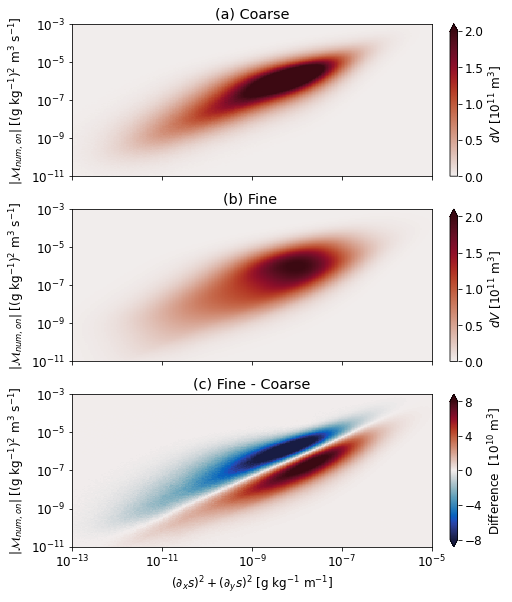

In [4]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1, figsize = (7,2.5*3.3), sharex = True, sharey = True, constrained_layout = True)

mappable = (parent_joint.T/1e11).plot(ax = ax[0], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable, ax = ax[0], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable1 = (child_joint.T/1e11).plot(ax = ax[1], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable1, ax = ax[1], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable2 = (hist_diff.T/1e10).plot(ax = ax[2], cmap = cmo.balance, add_colorbar = False, vmin = -8, vmax = 8)
cbar = fig.colorbar(mappable2, ax = ax[2], extend = 'both', label = r'Difference  [$10^{10}$ m$^3$]', ticks = [-8,-4,0,4,8], pad = 0.01)

for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_yticks([-11, -9, -7,-5,-3])
    ax[i].set_xticks([-13, -11, -9, -7,-5])
    ax[i].set_yticklabels(['10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$', '10$^{-3}$'])
ax[i].set_xticklabels(['10$^{-13}$', '10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$'])

for i in range(3):
    ax[i].set_ylabel(r'$|\mathcal{M}_{num,on}|$ [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
    
ax[0].set_title('(a) Coarse')
ax[1].set_title('(b) Fine ')
ax[2].set_title('(c) Fine - Coarse')
ax[2].set_xlabel(r'$(\partial_x s)^2+(\partial_y s)^2$ [g kg$^{-1}$ m$^{-1}$]')

In [5]:
def polyfit(x, y, degree, weights):
    '''
Fits x and y to an n degree polynomial, allows for weights to be added
  and returns the coefficients: i.e. y = ax + b and the coefficient of 
  determination based on weighted regrression. 
  
Inputs: 
------
x: x variable for WLS
y: desired y variable for WLS
degree: fit of polynomial (1 for linear)
weights: Vector of weights

Outputs:
------
results: Contains slope and y-intercept of regression
r2: Weighted coefficient of determination

Notes: 
------
r^2 = 1 - (SSR/SST), where
SSR = sum(w_i(y_i - y^hat)^2)
SST = sum(w_i(y_i - ybar)^2),
w_i = weights, i.e., dV
y_i = observed value of y
y^hat = predicted y value by WLS regression
ybar = weighted average value of observed y...
ybar = sum(w_i*y_i)/sum(w_i)
  
Source: Willett and Singer (1988) Another Cautionary Note...
    '''    
    results = {}

    coeffs = np.polyfit(x, y, degree, w = weights)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()
    
    #Predicted values for r^2
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)
    
    #Compute r^2 using 
    ss_residual = sum(weights*(y-yhat)**2)
    ss_total = sum(weights*(y-np.average(y, weights = weights))**2)
    r2 = (1-(ss_residual/ss_total))
    
    return results, r2

In [6]:
mnum_stack = mnum_subsample.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
sgradmag_stack = sgradmag_subsample.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
dV_stack = dV_subsample.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values

In [7]:
x = np.log10(sgradmag_stack) #salinity gradient magnitude
y = np.log10(np.abs(mnum_stack)) #numerical mixing
deg = 1 #linear fit in log space
w = np.sqrt(dV_stack) #weights 

#Run the fitting function
results_weighted, r2 = polyfit(x, y, deg, w) #weighted
print(results_weighted, r2)

{'polynomial': [0.8070237945318924, 0.5902091737236543]} 0.6019291044103474


In [8]:
#Sort 
mnum_sort = np.sort(x)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole = np.linspace(mnum_sort[0], mnum_sort[-1], 1000)
y_pred_weighted = results_weighted['polynomial'][0]*xwhole+results_weighted['polynomial'][1]

In [9]:
mnum_stackchild = mnum_subsample_child.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
sgradmag_stackchild = sgradmag_subsample_child.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values
dV_stackchild = dV_subsample_child.stack(z = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho']).values

In [10]:
x_child = np.log10(sgradmag_stackchild)
y_child = np.log10(np.abs(mnum_stackchild))
deg = 1 #linear fit in log space
w_child = np.sqrt(dV_stackchild) #weights 

#Run the fitting function
results_weighted_child, r2_child = polyfit(x_child, y_child, deg, w_child) #weighted
print(results_weighted_child, r2_child)

{'polynomial': [0.7565483350041383, -0.19412111722427394]} 0.4622398018292556


In [11]:
#Sort 
mnum_sort_child = np.sort(x_child)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole_child = np.linspace(mnum_sort_child[0], mnum_sort_child[-1], 1000)
y_pred_weighted_child = results_weighted_child['polynomial'][0]*xwhole_child+results_weighted_child['polynomial'][1]

In [21]:
parent_joint.T

<xarray.DataArray 'mnum_histogram' (mnum_bin: 249, sgradmag_bin: 249)>
dask.array<transpose, shape=(249, 249), dtype=float64, chunksize=(249, 249), chunktype=numpy.ndarray>
Coordinates:
  * sgradmag_bin  (sgradmag_bin) float64 -12.98 -12.95 -12.92 ... -5.048 -5.016
  * mnum_bin      (mnum_bin) float64 -10.98 -10.95 -10.92 ... -3.048 -3.016

Text(-12.9, -4.25, '$\\log_{10}|\\mathcal{M}_{num, on}|=$ 0.76$\\log_{10} (\\nabla_H s)^2$ - 0.19, $r^2 = $0.462')

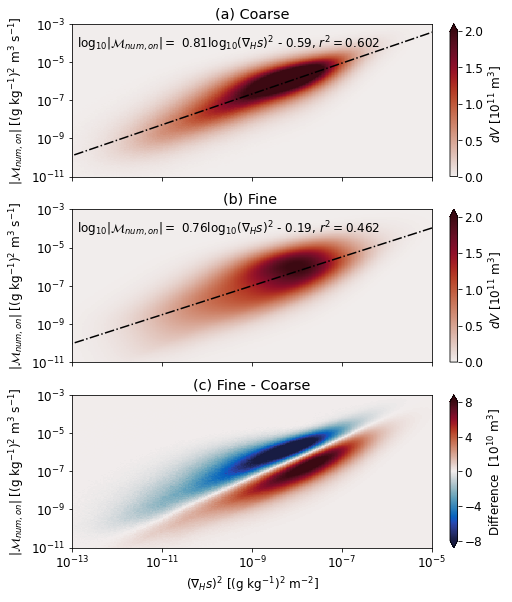

In [25]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1, figsize = (7,2.5*3.3), sharex = True, sharey = True, constrained_layout = True)

mappable = (parent_joint.T/1e11).plot(ax = ax[0], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable, ax = ax[0], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable1 = (child_joint.T/1e11).plot(ax = ax[1], cmap = cmo.amp, add_colorbar = False, vmin = 0, vmax = 2)
cbar = fig.colorbar(mappable1, ax = ax[1], extend = 'max', label = r'$dV$ [$10^{11}$ m$^3$]', pad = 0.01)
mappable2 = (hist_diff.T/1e10).plot(ax = ax[2], cmap = cmo.balance, add_colorbar = False, vmin = -8, vmax = 8)
cbar = fig.colorbar(mappable2, ax = ax[2], extend = 'both', label = r'Difference  [$10^{10}$ m$^3$]', ticks = [-8,-4,0,4,8], pad = 0.01)

for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_yticks([-11, -9, -7,-5,-3])
    ax[i].set_xticks([-13, -11, -9, -7,-5])
    ax[i].set_yticklabels(['10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$', '10$^{-3}$'])
ax[i].set_xticklabels(['10$^{-13}$', '10$^{-11}$', '10$^{-9}$', '10$^{-7}$', '10$^{-5}$'])

for i in range(3):
    ax[i].set_ylabel(r'$|\mathcal{M}_{num,on}|$ [(g kg$^{-1}$)$^2$ m$^3$ s$^{-1}$]')
    # ax[i].grid(ls = '--')
    
ax[0].set_title('(a) Coarse')
ax[1].set_title('(b) Fine ')
ax[2].set_title('(c) Fine - Coarse')
ax[2].set_xlabel(r'$(\nabla_H s)^2$ [(g kg$^{-1}$)$^2$ m$^{-2}$]')

ax[0].plot(xwhole, y_pred_weighted, lw = 1.5, ls = '-.', c = 'k')
ax[1].plot(xwhole_child, y_pred_weighted_child, lw = 1.5, ls = '-.', c = 'k')
ax[0].text(-12.9, -4.25, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + str(round(results_weighted['polynomial'][0], 2)) + r'$\log_{10} (\nabla_H s)^2$ - ' + str(round(np.abs(results_weighted['polynomial'][1]), 2)) + ', $r^2 = $' + str(round(r2, 3)))
ax[1].text(-12.9, -4.25, r'$\log_{10}|\mathcal{M}_{num, on}|=$ ' + str(round(results_weighted_child['polynomial'][0], 2)) + r'$\log_{10} (\nabla_H s)^2$ - ' + str(round(np.abs(results_weighted_child['polynomial'][1]), 2)) + ', $r^2 = $' + str(round(r2_child, 3)))
# fig.savefig('/d2/home/dylan/JAMES/figures/draft1/histogram_discussion_flipped.jpg', dpi = 300, bbox_inches="tight")     

# Histograms of u and v for the parent and child models, whole water column 

In [51]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
import glob
import pandas as pd
from xhistogram.xarray import histogram

path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg_parent = xroms.open_mfnetcdf(path)
ds_avg_parent, grid_parent = xroms.roms_dataset(ds_avg_parent)

path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
ds_avg_child = xroms.open_mfnetcdf(path)
ds_avg_child, grid_avg_child = xroms.roms_dataset(ds_avg_child)

#Corresponding location of the parent model subset. See 'check_grid.ipynb' for more information
xisliceparent = slice(271,404)
etasliceparent = slice(31,149)
xislicechild = slice(8,677-8)
etaslicechild = slice(8,602-8)

#Match the times of the parent and child models. Drop the first timestep after
#each restart, then match parent / child. 
timedrop = [np.datetime64('2010-06-18T18:30:00.000000000'), 
            np.datetime64('2010-06-19T18:30:00.000000000'), 
            np.datetime64('2010-07-09T18:30:00.000000000')]

ds_avg_child = ds_avg_child.where((ds_avg_child.ocean_time!= timedrop[0])
                                & (ds_avg_child.ocean_time!= timedrop[1])
                                & (ds_avg_child.ocean_time!= timedrop[2]),
                                   drop=True)

ds_avg_parent = ds_avg_parent.where(ds_avg_child.ocean_time==ds_avg_parent.ocean_time)

#Bin sizes for each variable: use 150 bins for each variable
ubins = np.linspace(-1,1,150)
vbins = np.linspace(-1,1,150)

u_parent = ds_avg_parent.u.isel(xi_u = xisliceparent, eta_rho = etasliceparent)
v_parent = ds_avg_parent.v.isel(xi_rho = xisliceparent, eta_v = etasliceparent)

u_child = ds_avg_child.u.isel(xi_u = xislicechild, eta_rho = etaslicechild)
v_child = ds_avg_child.v.isel(xi_rho = xislicechild, eta_v = etaslicechild)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst. Thanks stack exchange!"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

#Compute the surface salinity gradient magnitude
# sgradmag_surf_parent = surface_saltgradmag(ds_avg_parent, grid_parent).isel(eta_v = etasliceparent, xi_u = xisliceparent)
# sgradmag_surf_parent.name = 'sgradmag'
# sgradmag_surf_child = surface_saltgradmag(ds_avg_child, grid_avg_child).isel(eta_v = etaslicechild, xi_u = xislicechild)
# sgradmag_surf_child.name = 'sgradmag'

# #Create datelist every two hows for subsetting
# daterange = list(chunks(ds_avg_child.ocean_time.sel(ocean_time = slice('2010-06-03', '2010-07-13')), 2))
# print('Saving sgradmag histograms')
# for d in range(len(daterange)):
#     sgradmag_hist_parent = histogram(sgradmag_surf_parent.sel(ocean_time = daterange[d]), 
#                                      bins = [sgradbins], 
#                                      density = False)
#     sgradmag_hist_parent.name = 'sgradmag_histogram'

#     sgradmag_hist_child = histogram(sgradmag_surf_child.sel(ocean_time = daterange[d]), 
#                                     bins = [sgradbins], 
#                                     density = False)
#     sgradmag_hist_child.name = 'sgradmag_histogram'

#     path = '/d2/home/dylan/JAMES/histogram_outputs/surface_widerbins/sgradmag_parent_final_'+str(d)+'.nc'
#     sgradmag_hist_parent.to_netcdf(path)
    
#     path1 = '/d2/home/dylan/JAMES/histogram_outputs/surface_widerbins/sgradmag_child_final_'+str(d)+'.nc'
#     sgradmag_hist_child.to_netcdf(path1)

# #Compute the surface vorticity
# rv_surf_parent = surface_vorticity(ds_avg_parent, grid_parent).isel(eta_v = etasliceparent, xi_u = xisliceparent)
# rv_surf_parent.name = 'rvort'
# rv_surf_child = surface_vorticity(ds_avg_child, grid_avg_child).isel(eta_v = etaslicechild, xi_u = xislicechild)
# rv_surf_child.name = 'rvort'

# print('Saving vorticity histograms')
# for d in range(len(daterange)):
#     rv_hist_parent = histogram(rv_surf_parent.sel(ocean_time = daterange[d]), bins = [rvortbins], density = False)
#     rv_hist_parent.name = 'rel_vort_histogram'
    
#     rv_hist_child = histogram(rv_surf_child.sel(ocean_time = daterange[d]), bins = [rvortbins], density = False)
#     rv_hist_child.name = 'rel_vort_histogram'
    
#     path = '/d2/home/dylan/JAMES/histogram_outputs/surface_widerbins/rvort_parent_final_'+str(d)+'.nc'
#     rv_hist_parent.to_netcdf(path)
    
#     path1 = '/d2/home/dylan/JAMES/histogram_outputs/surface_widerbins/rvort_child_final_'+str(d)+'.nc'
#     rv_hist_child.to_netcdf(path1)
    

In [55]:
u_parent.attrs = ''
u_child.attrs = ''
v_parent.attrs = ''
v_child.attrs = ''

uhist_parent = histogram(u_parent, bins = [ubins], density = True, dim = ['ocean_time', 'xi_u', 'eta_rho', 's_rho'])
uhist_child = histogram(u_child, bins = [ubins], density = True, dim = ['ocean_time', 'xi_u', 'eta_rho', 's_rho'])

vhist_parent = histogram(v_parent, bins = [vbins], density = True, dim = ['ocean_time', 'xi_rho', 'eta_v', 's_rho'])
vhist_child = histogram(v_child, bins = [vbins], density = True, dim = ['ocean_time', 'xi_rho', 'eta_v', 's_rho'])

In [56]:
uhist_parent.name = 'u_pdf_parent'
uhist_parent.to_netcdf('u_pdf_parent.nc')
vhist_parent.name = 'v_pdf_parent'
vhist_parent.to_netcdf('v_pdf_parent.nc')

In [57]:
uhist_child.name = 'u_pdf_child'
uhist_child.to_netcdf('u_pdf_child.nc')
vhist_child.name = 'v_pdf_child'
vhist_child.to_netcdf('v_pdf_child.nc')

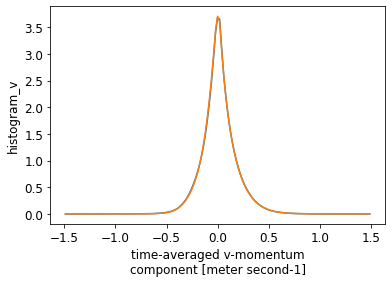

In [50]:
histogram(v_parent[200:350], bins = [vbins], density = True, dim = ['ocean_time', 'xi_rho', 'eta_v', 's_rho']).plot()
histogram(v_child[200:350], bins = [vbins], density = True, dim = ['ocean_time', 'xi_rho', 'eta_v', 's_rho']).plot()

In [58]:
uhist_parent = xr.open_dataset('u_pdf_parent.nc')
vhist_parent = xr.open_dataset('v_pdf_parent.nc')

uhist_child = xr.open_dataset('u_pdf_child.nc')
vhist_child = xr.open_dataset('v_pdf_child.nc')

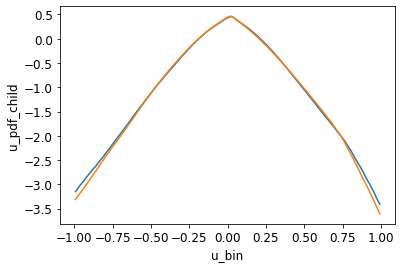

In [62]:
np.log10(uhist_parent.u_pdf_parent).plot()
np.log10(uhist_child.u_pdf_child).plot()

In [64]:
vhist_parent.v_pdf_parent.semilogy()
vhist_child.v_pdf_child.semilogy()

AttributeError: 'DataArray' object has no attribute 'semilogy'